In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15819, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 15819 (delta 18), reused 8 (delta 8), pack-reused 15786 (from 3)
Receiving objects: 100% (15819/15819), 6.39 MiB | 26.58 MiB/s, done.
Resolving deltas: 100% (11523/11523), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your env

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/kaggle/input/dataset/COCO_output/train/coco_annotations.json", "/kaggle/input/dataset/COCO_output/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/dataset/COCO_output/val/coco_annotations.json", "/kaggle/input/dataset/COCO_output/val")

In [5]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[12/19 10:38:31 d2.data.datasets.coco]: Loaded 399 images in COCO format from /kaggle/input/dataset/COCO_output/train/coco_annotations.json


In [6]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[12/19 10:38:47 d2.data.datasets.coco]: Loaded 133 images in COCO format from /kaggle/input/dataset/COCO_output/val/coco_annotations.json


In [7]:
from matplotlib import pyplot as plt

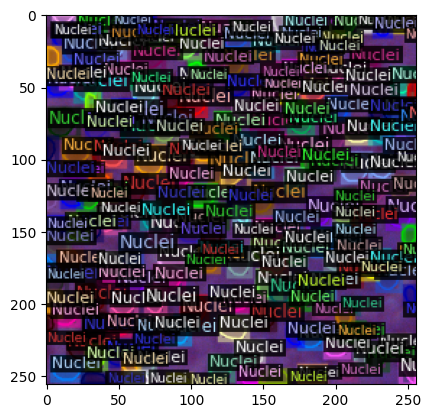

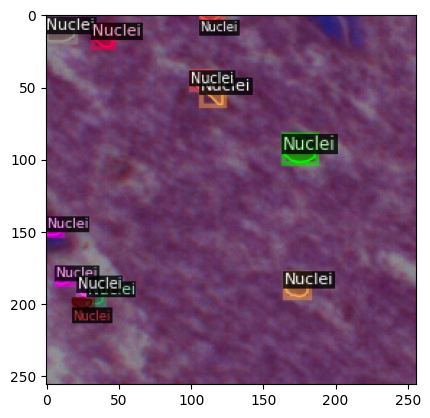

In [8]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/kaggle/working/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[12/19 10:40:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 206MB/s]                             


In [13]:
trainer.train() #Start the training process

[12/19 10:40:54 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/19 10:41:05 d2.utils.events]:  eta: 0:05:56  iter: 19  total_loss: 6.758  loss_cls: 1.402  loss_box_reg: 0.5072  loss_mask: 0.6924  loss_rpn_cls: 3.935  loss_rpn_loc: 0.2798    time: 0.3667  last_time: 0.3469  data_time: 0.0129  last_data_time: 0.0066   lr: 4.9953e-06  max_mem: 1941M
[12/19 10:41:21 d2.utils.events]:  eta: 0:06:04  iter: 39  total_loss: 4.983  loss_cls: 1.354  loss_box_reg: 0.6051  loss_mask: 0.687  loss_rpn_cls: 1.953  loss_rpn_loc: 0.263    time: 0.3833  last_time: 0.3549  data_time: 0.0059  last_data_time: 0.0053   lr: 9.9902e-06  max_mem: 2067M
[12/19 10:41:29 d2.utils.events]:  eta: 0:06:00  iter: 59  total_loss: 3.26  loss_cls: 1.23  loss_box_reg: 0.6621  loss_mask: 0.6776  loss_rpn_cls: 0.5079  loss_rpn_loc: 0.21    time: 0.3830  last_time: 0.4179  data_time: 0.0059  last_data_time: 0.0058   lr: 1.4985e-05  max_mem: 2067M
[12/19 10:41:36 d2.utils.events]:  eta: 0:05:52  iter: 79  total_loss: 2.942  loss_cls: 1.043  loss_box_reg: 0.681  loss_mask: 0.6616  los

In [14]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/kaggle/working/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [15]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/19 10:48:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/models/Detectron2_Models/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

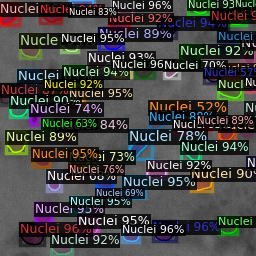

In [16]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/19 10:48:54 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[12/19 10:48:54 d2.data.datasets.coco]: Loaded 133 images in COCO format from /kaggle/input/dataset/COCO_output/val/coco_annotations.json
[12/19 10:48:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Nuclei   | 6105         |
|            |              |
[12/19 10:48:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/19 10:48:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/19 10:48:54 d2.data.common]: Serializing 133 elements to byte tensors and concatenating them all ...
[12/19 10:48:54 d2.data.common]: Serialized dataset takes 1.61 MiB
[12/19 10:48:55 d2.evaluation.evaluator]: Start inference on 133 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/19 10:48:56 d2.evaluation.evaluator]: Inference done 11/133. Dataloading: 0.0015 s/iter. Inference: 0.0939 s/iter. Eval: 0.0230 s/iter. Total: 0.1184 s/iter. ETA=0:00:14
[12/19 10:49:01 d2.evaluation.evaluator]: Inference done 55/133. Dataloading: 0.0016 s/iter. Inference: 0.0939 s/iter. Eval: 0.0200 s/iter. Total: 0.1156 s/iter. ETA=0:00:09
[12/19 10:49:06 d2.evaluation.evaluator]: Inference done 100/133. Dataloading: 0.0016 s/iter. Inference: 0.0937 s/iter. Eval: 0.0185 s/iter. Total: 0.1139 s/iter. ETA=0:00:03
[12/19 10:49:10 d2.evaluation.evaluator]: Total inference time: 0:00:14.732353 (0.115097 s / iter per device, on 1 devices)
[12/19 10:49:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.094173 s / iter per device, on 1 devices)
[12/19 10:49:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/19 10:49:10 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[12/19 10:49:10 d2.evaluation.coco

Numero totale di cellule: 61
Area della maschera: 962 pixel²
Densità cellulare: 0.0634 cellule/pixel²


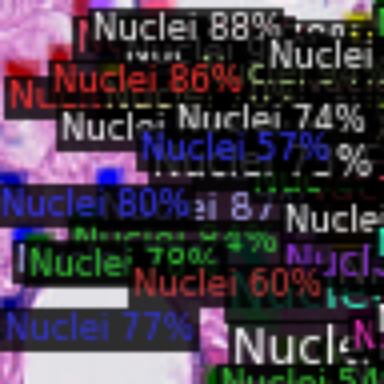

In [32]:
# Leggere l'immagine
new_im = cv2.imread("/kaggle/input/camelyon17/patch_patient_046_node_4_x_1664_y_18144.png")
outputs = predictor(new_im)

# Disegnare le predizioni
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Ingrandire l'immagine
resized_img = cv2.resize(out.get_image()[:, :, ::-1], None, fx=4, fy=4, interpolation=cv2.INTER_LINEAR)

# Mostrare l'immagine ingrandita
cv2_imshow(resized_img)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# Directory path to the input images folder
input_images_directory = "/kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches"

# Output directory where the segmented images will be saved
output_directory = "/kaggle/working/test_results"  # Replace this with the path to your desired output directory
os.makedirs(output_directory, exist_ok=True)

# Loop over the images in the input folder
def process_images_in_directory(input_dir, output_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png')): 
                image_path = os.path.join(root, file)
                new_im = cv2.imread(image_path)

                # Perform prediction on the new image
                outputs = predictor(new_im)  # Replace `predictor` with your initialized model

                # Use Visualizer to draw the predictions on the image
                v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
                out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

                # Create the output path, maintaining the folder structure
                relative_path = os.path.relpath(image_path, input_dir)
                result_path = os.path.join(output_dir, os.path.splitext(relative_path)[0] + "_result.png")
                os.makedirs(os.path.dirname(result_path), exist_ok=True)

                # Save the segmented image
                cv2.imwrite(result_path, out.get_image()[:, :, ::-1])
                print(f"Image at {image_path} processed")

# Process all images in the directory
process_images_in_directory(input_images_directory, output_directory)

print("Segmentation of all images in subfolders completed.")

Image at /kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches/patient_039_node_1/patch_patient_039_node_1_x_10944_y_35200.png processed
Image at /kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches/patient_039_node_1/patch_patient_039_node_1_x_12032_y_27616.png processed
Image at /kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches/patient_039_node_1/patch_patient_039_node_1_x_20128_y_36640.png processed
Image at /kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches/patient_039_node_1/patch_patient_039_node_1_x_14560_y_29344.png processed
Image at /kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches/patient_039_node_1/patch_patient_039_node_1_x_10016_y_39392.png processed
Image at /kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches/patient_039_node_1/patch_patient_039_node_1_x_7296_y_39744.png processed
Image at /kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches/patient_039_node_1/patch_patient_039_node_1_x_7296_y_36800.png processed
Image at /kaggle/input/camelyon17-v1-0/came

KeyboardInterrupt: 

In [50]:
import csv
from skimage.measure import regionprops, label


# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/kaggle/input/camelyon17-v1-0/camelyon17_v1.0/patches"

# Output directory where the CSV file will be saved
output_csv_path = "/kaggle/working/test_results/output_objects.csv"  # Replace this with the path to your desired output CSV file
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# Gather all image paths
image_paths = []
for root, _, files in os.walk(input_images_directory):
    for file in files:
        if file.endswith(('.png')):  # Process only PNG files
            image_paths.append(os.path.join(root, file))

# Total number of images
total_images = len(image_paths)
print(f"Total Images: {total_images}")

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Path", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox", "Number of Cells", "Cells Density"])  # Add more columns as needed

    start_time = time.time()  # Record the start time of the entire process

    # Loop over the images
    for idx, image_path in enumerate(image_paths):
        image_start_time = time.time()  # Start time for the current image
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Replace `predictor` with your initialized model

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)
        num_cells = len(props)
        mask_area = np.sum(mask)

        # Calculate cell density
        cell_density = num_cells / mask_area if mask_area > 0 else 0

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                class_name = 'Unknown'  # If class label is missing

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_path, class_name, object_number, area, centroid, bounding_box, num_cells, cell_density])

        # Calculate time taken for the current image
        image_time_taken = time.time() - image_start_time

        # Calculate estimated remaining time
        images_processed = idx + 1
        elapsed_time = time.time() - start_time
        avg_time_per_image = elapsed_time / images_processed
        remaining_time = avg_time_per_image * (total_images - images_processed)

        # Print progress
        print(f"Processed {images_processed}/{total_images} images. "
              f"Time for current image: {image_time_taken:.2f}s. "
              f"Estimated time remaining: {remaining_time:.2f}s.")

print("Object-level information saved to CSV file.")

KeyboardInterrupt: 